### Importing the necessary modules

In [1]:
import holoviews as hv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xa
import importlib
from typing import List
import holoviews as hv
from IPython.core.display import display, HTML
import natsort
np.set_printoptions(linewidth=200)
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import sys
from IPython.lib import deepreload

import kagglelib as kglib

class disabled_print:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python
def reload_kglib() -> None:
    with disabled_print():
        deepreload.reload(kglib, exclude={key for (key, value) in sys.modules.items() if "kagglelib" not in key})

# Data: where the truth lies OR # Guitar or Drums?
# State of Machine Learning and Data Science 2020, Revisited

### Table of Contents
0. Introduction
1. Methodology and key differences
2. EDA for filtering "pollution", spam and user error
3. Data Scientists Profile
4. Data Scientists Programming and ML Experience
5. Salary DS and other roles(company size?)
6. (Technology ?)
7. Conclusion
8. Appendix A: EDA on spam and user error, methodology.
9. Appendix B: Exploring Q & A; suggestions for future Surveys.

## Introduction

The Kaggle DS & ML Survey is an open online survey receiving thousands of responses from all over the world, offering unique insights.  
Being a global online survey it is affected by a factor that Machine Learning is famous for mitigating: spam, and user error.  
According to the Survey Methodology, "spam" has been excluded from the data.

Using Exploratory Data Analysis (EDA) we find that without dropping possible outliers, a large part of the data should be excluded for being spam or for having abnormal, irregular values.  
Using relatively tolerant criteria, we identify 3859 such observations (19% of the dataset) and after filtering them we get significantly different results than the "Executive Summary" and all other EDAs, that do not filter the data.

Focusing on the issue of compensation, we account for the wide global diversity by grouping countries according to the World Bank "Income Groups" definition.  
We find that the median salary is higher to a significant degree and the distribution is shifted towards higher salary thresholds.  
For example, the median salary for India-based Data Scientists is double than what the unfiltered data suggest.

We also reconstruct the various classes (bins) in which the data are provided, accounting for their width and their underlying properties.  
We find that the age distribution density is much higher in the younger groups than the unadjusted bins show.

The weight of USA observations is disproportional, so we exclude the USA from global or group aggregates, offering a different view on the pronounced symmetric difference.  
US-based data scientists are more experienced and for the same levels of experience, they earn almost double the amount than their colleages residing in other high income countries.

Combining these four features, our results diverge to a large extend from the "Executive Summary", and all other analyses that do not filter the data, especially with respect to our focus, the issue of compensation levels.

Our findings add to the understanding of the data, providing information to students, professionals and interested companies in order to optimize their strategical behavior with respect to compensation, relocation and remote work.  
At the same time, we provide a fundamentally different methodological framework on a number of issues.

To explore various scenarios we have created a dedicated python "library" with functions, which may be parameterized and reused for various filtering thresholds and different data subsets.  
The whole notebook (other than the text) can be reparametarized by setting one different argument (or more).

In Appendix A we discuss in detail out methodology and the datasets we use.

In Appendix B, we provide another distinct result of our exploratory analysis;
a concise list of suggestions for future surveys.

# 1. Methodology and key differences


### a) Exploring the questions, the answer choices and the dataset for spam, errors and unacceptable values

The first part of our EDA is dedicated to exploring abnormal/invalid observation values that have not be flagged as spam by the survey system, but should be definetely excluded from the data.  
We use the official "Executive Summary" as a benchmark but our results also differ from all other EDAs that explore the data without filtering them first.

The number of unacceptable values and the criteria that we had to set, highlight the principal importance and challenges of exploring the data for errors and cleaning them before embarking on any other kind of analysis.

Besides unacceptable values, we find mispecifications in "Questions" and "Answer Choices" that may lead to unfounded conclusions if they go unnoticed.



### b) Adjusting for cross-country economic differences

The importance of meaningful information on compensation levels cannot be understated in a field that transcends national borders like few others.  
Nevertheless, the differences among different economies are so profound that a global view on Data Scientist salary distribution shows an "everything goes" result.

Besides a robust single country median calculation, we group the countries according to the World Bank Income Groups and explore the salary distribution per group of countries. This allows us in turn to explore in a meaningful way the effect that experience levels have on salary in each countries income group. We select "experience" as the variable that may explain differences in salary levels and find that it leads to significant within-group differences for all country groups and countries.



### c) Reconstruction of data aggregated bins (classes)

Using different classes width for aggregating observations is convenient and informative.  
But convenience comes with a trade-off; a large amount of information is lost.  
If bins are created unequal, this may lead to "over" or "under" representation of data, depending on the relative width difference and the number of observations.  
It may  also distort provided information and create optical "illusions" in visual representations.

We reconstruct bins using various ways where we find this phenomenon to exist in the data and we gain new and useful information.



### d) Examine USA versus Rest of World (RoW) symmetric differences

When comparing the aggregate metrics of a subset of the data with the overall aggregates we examine whether the subset in question influences heavily the aggregated values.  
It is informative to compare a subset with low number of observations against the total, to asses how it measures against it.

But, for a subset with substantial weight, information is distorted since the subset defines the total to a significant degree.  
In that case, comparing the symmetric difference can add valuable information for both sides. Therefore, when comparing the USA, we exclude it from the total.

## 2. EDA for filtering "pollution", spam and user error.

In [2]:
# load unfiltered Kaggle data with optimised labels andcolumns for EDA
udf = kglib.load_udf()

seconds = [30, 45, 60, 90]
super_fast_participants = pd.DataFrame(
    {
        "seconds": seconds,
        "fast_participants": [len(udf[udf.duration <= sec]) for sec in seconds],
    }, 
)
# super_fast_participants

dataset = udf
fastest = dataset.duration.nsmallest(1).values[0]
fastest_time_n = dataset.duration.nsmallest(300).tail(1).values[0]
slowest = dataset.duration.nlargest(1).values[0]
slowest_time_n = dataset.duration.nlargest(300).tail(1).values[0]
#fastest, fastest_time_n, (slowest/3600),  (slowest_time_n/3600)

# (udf.duration <= 3000).sum()
# udf[udf.duration < 3000].duration.hist(bins=200, grid=False)
# udf.duration.median()
# udf.duration.mean()

A key difference of our analysis is that the first part of our EDA is dedicated to exploring abnormal/invalid observation values that have not be flagged as spam by the survey system, but should definetely be excluded from the data.  
The number of unacceptable values and the criteria that we had to set, highlight the complexity, the challenges but mostly the principal importance of exploring the data and cleaning them before embarking on any other kind of analysis.  
Examining the very first variable we find that there are 347 participants that completed the survey in less than 60 seconds.  That is arguably not enough time to read the questions.

| threshold (sec) | No. participants |
|-----------------|------------------|
| 30              |  29              |
| 45              | 166              |
| 60              | 347              |
| 90              | 630              |



The fastest "participation" time is 20 seconds, the 300th faster is 56 seconds, meaning that 300 participants "completed" the Survey in 56 seconds or less.  
The slowest survey completion time is 318 hours (almost two weeks) and the 300th slowest time is 48 hours.  
300 participants "completed" the Survey in more than two days.  
Nevertheless, instead of choosing a reasonable minimum and maximum duration thresholds, we use other qualitative criteria, and we manage to filter out a large part of these observations.

### The criteria we use to clean the data are:

### Criterion 1: Participants who did not actually participate in the survey.

In [3]:
# udf.columns[:7].values

orig_df = kglib.load_orig_kaggle_df()
temp_df = orig_df.iloc[:, 7:]

only_answer_demographic = (
    (temp_df == 'None')
    | temp_df.isnull()
).all(axis=1)

#len(orig_df[only_answer_demographic])

This includes observations with values only for the first set of general demographic questions and no other relevant information that adds any value concerning DS & ML.  
We drop these irrelevant observation values as they do not provide further information relative to the scope of the survey.  
We could also add a threshold for minimum 3 Not-Nan values, but being lenient, we merely drop those who only answered demographic questions, plus the next one and then quit the survey.

Using our first criterion, we identify and drop 1082 observations.  
Note that, not using criterion 1 does not affect our main results with respect to salary levels at all.

### Criterion 2: Participants that are too young for their experience (in Programming or Machine Learning).

#### Below we show some examples of that criterion:

In [4]:
is_too_young_for_experience = (
    (udf.age <= "24")
    & (udf.code_exp == "20+")
)
udf[is_too_young_for_experience].iloc[:,1:7].head(3)

,age,gender,country,education,role,code_exp
3549,22-24,Woman,Other,Master’s,Data Scientist,20+
4103,18-21,Nonbinary,Other,No answer,Currently not employed,20+
6147,18-21,Man,Turkey,Bachelor’s,Machine Learning Engineer,20+


Obviously, it is impossible to be 24 years old or less and have 20+ years of experience.

### Criterion 3: Participants whose salary, experience, age and country of residence are mutually exclusive.

As an example, it is impossible to be less than 21 years old, working as an employee and earn above 500,000 usd as a yearly salary, in any country in the world.  
A closer examination of these observations shows that spam often is extensive.  

#### Below we show some examples of that criterion:

In [5]:
too_young_high_salary = udf[
    (udf.age <= "21")
    & (udf.salary.isin(["300000-499999", "500000-999999"]))
].dropna(axis=1).head()
too_young_high_salary.iloc[:,1:11].head(3)

,age,gender,country,education,role,code_exp,employees,team_ds,company_ml_use,salary
39,18-21,Man,India,Bachelor’s,Data Scientist,3-5,0-49,20+,"We have well established ML methods (i.e., mod...",500000-999999
543,18-21,Man,India,Bachelor’s,Data Scientist,0-1,0-49,0,"We have well established ML methods (i.e., mod...",300000-499999
1101,18-21,Self-describe,Other,Doctoral,Other,0,10000+,0,I do not know,500000-999999


#### Likewise, as shown in the data below, it is impossible to reside in the US, have more than 10 years experience and earn less than 1000 usd per year.

In [6]:
high_exp_bins = ["10-20", "20+"]
is_high_exp = (
    udf.code_exp.isin(high_exp_bins)
    | udf.ml_exp.isin(high_exp_bins)
)
# udf[is_high_exp]

extemely_low_salary_high_exp = (
    (is_high_exp) &
    (udf.salary_threshold <= 1000)
)
# udf[is_low_salary_high_exp].Mdropna(axis=1)

USA_is_low_salary_high_exp = (
    udf[
        (extemely_low_salary_high_exp)
        & (udf.country == "USA")
    ].dropna(axis=1).iloc[:, 3:20]
).dropna(axis=0).head(3)
USA_is_low_salary_high_exp

,country,education,role,code_exp,Q8,Q11,Q13,ml_exp,employees,team_ds,company_ml_use,salary,code_level,ml_level,salary_threshold,income_group,country_avg_salary
557,USA,Doctoral,Data Scientist,20+,Python,A personal computer or laptop,Never,0-1,0-49,0,We are exploring ML methods (and may one day p...,0-999,3. high XP,1. low XP,1000.0,3. High,65835.577645
891,USA,Master’s,Data Engineer,10-20,Python,"A cloud computing platform (AWS, Azure, GCP, h...",Once,1-2,10000+,20+,"We have well established ML methods (i.e., mod...",0-999,3. high XP,1. low XP,1000.0,3. High,65835.577645
1313,USA,Master’s,Data Scientist,20+,R,A personal computer or laptop,Never,4-5,0-49,0,No (we do not use ML methods),0-999,3. high XP,2. med XP,1000.0,3. High,65835.577645


Using simple filtering we could drop hundreds of observations on the spot.  
To move beyond simple filtering, and take into account the wide global differnces, we construct various combinations of age, salary, country and experience, taking the following steps:

* a) we obtain the annual average salary for each country ("country_avg_salary") using official sources where available.

Then, to avoid excluding outliers we set:

* b) the corresponding "salary_threshold" for each observation, as the upper bound of Kaggle data salary bins.

* c) the country adjusted "low_salary_high_exp" threshold, two thresholds below the country average, applicable only for experience values greater or equal to 10 years. 
   
* d) the country adjusted "too_low_salary" threshold. We multiply the country average by 0.33 and set the rejection rate to be two thresholds below.  
    
* e) the "high_salary_low_exp" threshold, which is above 300000 for all countries.

For a detailed account of the various third party data sets and the methodology applied, please read the Appendix A or review the submitted code.  
As a side note, our thresholds leave more than enough room for part-time employeed participants.  
Since, the question explicitly asks for yearly salary, observations that contain the value of very limited part-time salary as the yearly value, inhibit any meanigful exploration of proper yearly salary data.  
To the extent that such values are present in the dataset, they are the result of user or design error and should be excluded from the data, evenmore so when examing salary distributions and factors that might explain it.  
In order to get a comprehensive view of the data, and benchmark the filtering method, we use these observations to compare the difference between the two data sets (filtered, unfiltered).

### In the table below we show a sample of the thresholds we calculate.

In [7]:
# kglib.get_threshold(65800, 0)
#kglib.get_threshold(65800 * 1/3, 2)


tresholds_df = kglib.load_thresholds_df()
usa_thresholds = tresholds_df[tresholds_df.country == "USA"]
#usa_thresholds
tresholds_df.sample(5, random_state=10)

,country,income_group,country_avg_salary,too_low_salary,low_salary_high_exp,high_salary_low_exp
87,Hungary,3. High,15314.905535,4000,10000,500000
26,Brazil,2. Upper middle,8766.000000,1000,5000,500000
76,Greece,3. High,23937.193780,5000,15000,500000
68,France,3. High,40914.646375,7500,30000,500000
78,Grenada,2. Upper middle,NaN,300000,300000,500000


For country category "Other", we set the minimum thresholds, since the country names that would allow us to obtain each county's average salary are missing.  
Our classification rules are intentionally too lenient and could most probably be much stricter.  
This can be done on the spot, by setting different parameters in the relevant dedicated filtering function.  
We explored various scenaria and we demonstrate a scenario on the very lenient spectrum, with respect to filtering.  
Nevertheless, even with minimum strictness we get significantly different results than any other EDA that uses the data as is.  


The significance of these values depends on the overall size of the subset they belong to and the respective calculated metric.  
For example, a salary of 500,000 outweighs 100 observations of a salary of 5000.  
Similarly, dropping 10 observations from a range of 15 observations, means that the size of the category is one third of its initial unfiltered size.  

In [8]:
fdf = kglib.filter_df(udf, print_filters=False)
#filtered_obs_size = len(udf) - len(fdf)
#filtered_obs_size,  filtered_obs_size/len(udf), len(fdf)

dataset = fdf
fastest = dataset.duration.nsmallest(1).values[0]
fastest_time_n = dataset.duration.nsmallest(300).tail(1).values[0]
slowest = dataset.duration.nlargest(1).values[0]
slowest_time_n = dataset.duration.nlargest(300).tail(1).values[0]
# fastest, fastest_time_n, (slowest/3600),  (slowest_time_n/3600)
# pros_fdf.loc[pros_fdf.index == 16761].dropna(axis=1)

pros_fdf = fdf[
    (fdf.role != "Student")
    & ((fdf.role != "Currently not employed"))
]

dataset = pros_fdf
fastest_completion = dataset.duration.nsmallest(1).values[0]
time_to_complete_faster_thousand = dataset.duration.nsmallest(1000).tail(1).values[0]
slowest_completion = dataset.duration.nlargest(1).values[0]
time_to_complete_slower_thousand = dataset.duration.nlargest(1000).tail(1).values[0]
# fastest_completion, time_to_complete_faster_thousand, (slowest_completion/3600), (time_to_complete_slower_thousand/3600)

Many of the values that we filter are part of the same observation row, a fact that adds support to the decision to exclude them from the data.  
As a result, the number of observations that we drop using each filter depends on the order the filters are applied.

#### In total, we drop 3859 observations, 19% of the unfiltered data set.

#### The filtered data set contains 16177 rows.


After filtering the data, duration times are not so extreme, but we still have values that could be dropped if we set lenient min and max time criteria.  
The two weeks completion time observation is still in the data, the fastest participant took 48 seconds, 300 participants made it in 123 seconds or less.

If we exclude "Students" and "Curenty not Employeed" duration times are more reasonable.  
The fastest participant completed the Survey in 49 seconds, the 300 faster participants took less than 5 minutes and the 300 slower made it after more than 19,5 hours.

# 3. Data Scientists Demographic Profile

In [9]:
uds = kglib.load_role_df(udf, role="Data Scientist")
fds = kglib.load_role_df(fdf, role="Data Scientist")
udf, uds, fdf, fds = map(kglib.keep_demo_cols, (udf, uds, fdf, fds))
dataset1, dataset2 = uds, fds
# len(fdf), len(fds)

### After filtering the data, the dataset contains 16177 observations.
#### of which, 2090 are Data Scientists.

## a. Gender

#### Men percentage is 1% higher compared to the unfiltered data,
marginally better in terms of gender gap than the previous year.

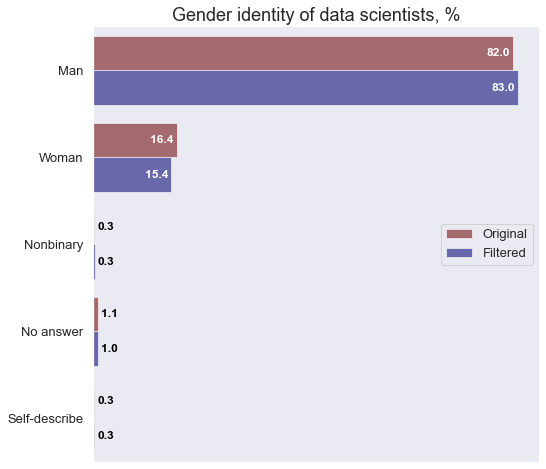

In [10]:
column = "gender"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    stack_label="No. participants",
    as_percentage=True,
    order=["Man", "Woman", "Nonbinary", "No answer", "Self-describe"],
)

kglib.sns_plot_value_count_comparison(
    df=df,
    width=8,
    height=8,
    orientation="h",
    order_by_labels=False,
    legend_location="center right",
    title="Gender identity of data scientists, %"
)

## b. Age

#### Data scientists in the workplace, in the age of 18-21, are not that many after all.
Still more than 60% of Data Scientists are below the age of 35 years old.

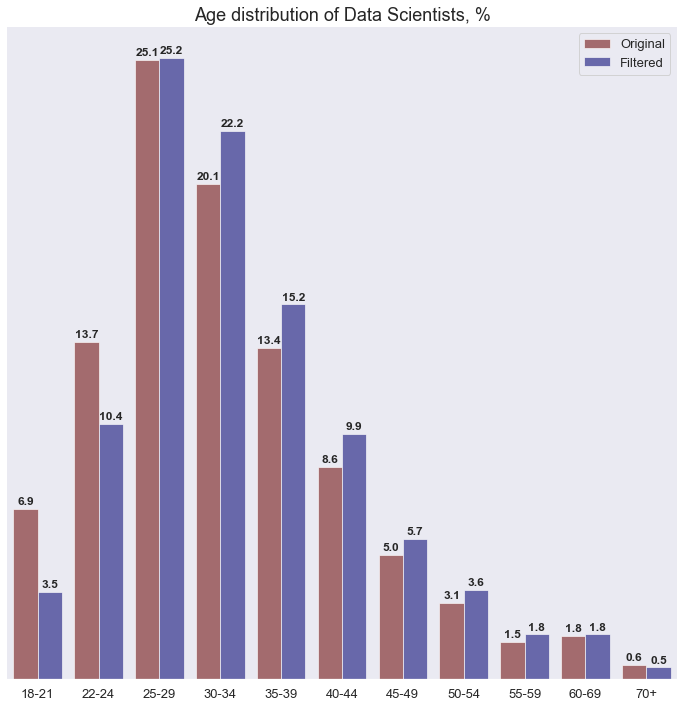

In [11]:
column = "age"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    stack_label="No participants",
    as_percentage=True
)
# df
kglib.sns_plot_value_count_comparison(
    df,
    width=12,
    height=12,
    orientation="v",
    title="Age distribution of Data Scientists, %"
)

#### 
There is something more interesting concerning the whole survey distribution if we examine the bin widths.  
The age Bbn of 18-21 spans over 4 years, the bin 22-24 over 3 years, and the 25-29 bin spans over 5 years.  
This ad hoc bin creation is informative if you focus on any of these bins separately, but distorts the comparison between the three.  
The relative size of the 18-21 bin is by definition augmented, while the 22-24 bin is by definition much smaller than the 25-29 bin.

Using, for simplicity, the average number of participants per year in each bin and assuming equal distribution among each bin years, we get a different story.  
The information the "adjusted bins" graph conveys is that it can be read as a potential growth and popularity trend of Kaggle.

Adjusting the age bins, we find that in the 20-24 cohort there are 30% more participants than in the 25-29 cohort, and this is a noteable future growth trend prediction.  
Plus, there are a lot more participants in the 18-19 age cohort than meets the eye.   
Note that the 18-19 bin spans over two years.   
Again, taking the average per year, the 18-19 bin density is definetely greater than the 25-29 bin, showing that Kaggle is way more popular to "newcomers".  
The results shown below hold whether we use filtered or unfilterd data.

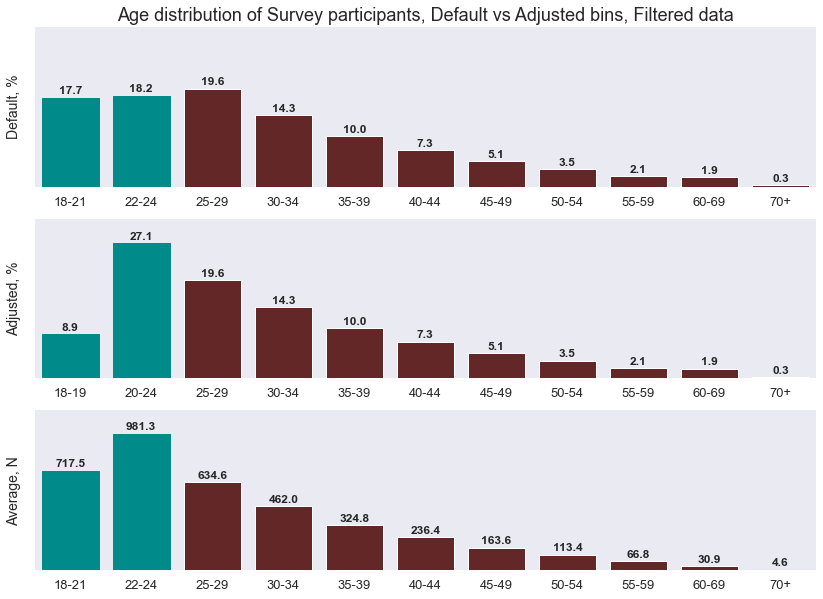

In [12]:
dataset = fdf
kglib.sns_plot_age_distribution(
    dataset,
    width=14,
    height=10,
    title="Age distribution of Survey participants, Default vs Adjusted bins, Filtered data"
)

#for unfiltered data we set:
# dataset = udf
# kglib.sns_plot_age_distribution(dataset, width=14, height=12,title="Survey Age distribution - Default VS Proposed bins, Uniltered data")

## c. country

####  The difference between USA and India is narrow, the UK is third in terms of participants and the Netherlands are inclused in the top 15 countries. 

Ps. There are two different "answer choices" for Korea, 76 obs for "Republic of Korea" and 190 for "South Korea".  
Since both are associated with South Korea, we aggregate them as South Korea.

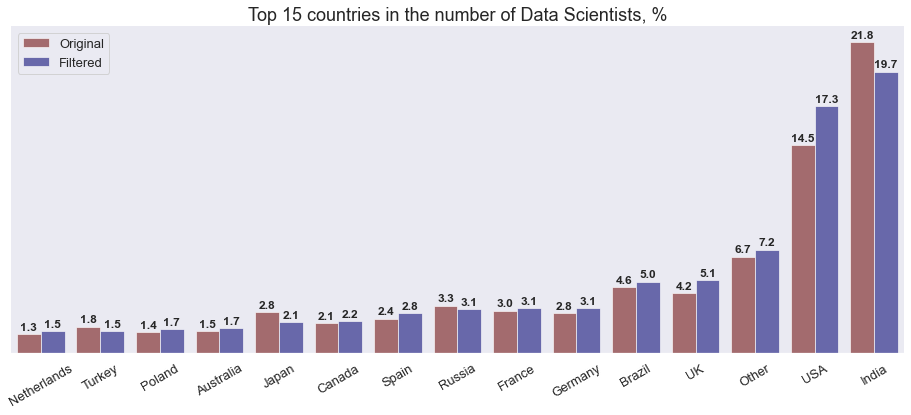

In [13]:
Korea = orig_df[orig_df.Q3.str.contains("Korea")].groupby('Q3').size()
# Korea

dataset1, dataset2 = uds, fds
column = "country"
df = kglib.get_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    as_percentage=True
)

df = df[df.Filtered > 1.5]
df = df.sort_values(by="Filtered")
df = kglib.stack_value_count_comparison(df, "participants (%)")

kglib.sns_plot_value_count_comparison(
    df,
    width=16,
    height=6,
    orientation="v",
    order_by_labels=False,
    x_ticklabels_rotation=30,
    title="Top 15 countries in the number of Data Scientists, %"
)

## d. Education

#### After filtering the data, PhD holders are reduced by one third.

There is a more important discovery though.  
The question is set in a way that does not allow for definite inferences about the current level of education of participants.  
Even if "Data Scientists" are not "Students", we can not be 100% certain whether they replied about the level of education they have already attained or about the one they plan to attain.  
#### Therefore, we exclude the dimension of education from our analysis as any EDA based on information provided by this question would be unfounded.

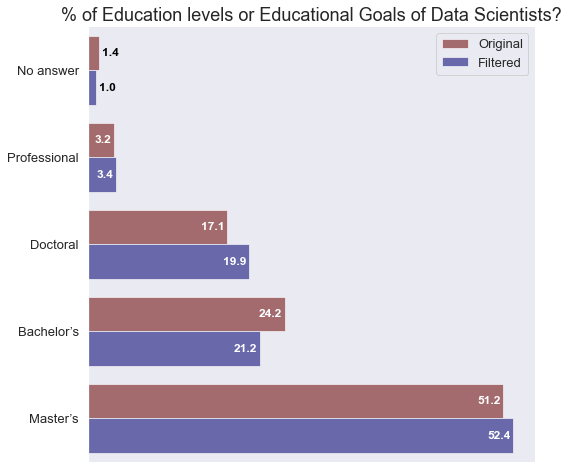

In [14]:
column = "education"
order = [
    'No answer',
    'High school'
    'Studies without a degree',
    'Professional',
    'Doctoral',
    'Bachelor’s',
    'Master’s',
]

df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    stack_label="participants (%)",
    as_percentage=True,
    order=order,
)

reload_kglib()
kglib.sns_plot_value_count_comparison(
    df,
    width=8,
    height=8,
    orientation="h",
    order_by_labels=False,
    title="% of Education levels or Educational Goals of Data Scientists?"
)

# 4. Data Scientists Programming and ML Experience

### 4a. Programming Experience USA vs RoW

#### The percentage of Data Scientitsts in the US with more than 20 years of Programming Experience is double than in the RoW.  
Similarly, more than the two thirds of Data Scientists in the US, have more than 5 years of experience.  
On the other hand, there is a shortage of Experienced Data Scientists in the RoW, since more than 50% have less than 5 years of Programming Experience.

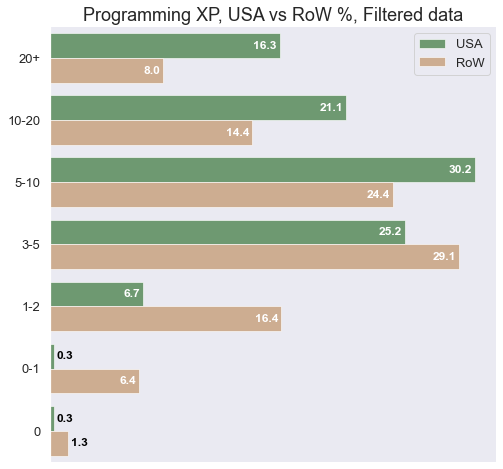

In [15]:
fds_usa = fds[fds.country == "USA"]
fds_non_usa = fds[fds.country != "USA"]
dataset1 = fds_usa
dataset2 = fds_non_usa

column = "code_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
)


kglib.sns_plot_value_count_comparison(
    df,
    width=8,
    height=8,
    orientation="h",
    order_by_labels=False,
    title="Programming XP, USA vs RoW %, Filtered data",
    palette=[sns.desaturate("green", 0.75), "peru"],
)

####  Using the unfiltered data and excluding the US from the global aggregate, we see that:  
#### the percentage of Data Scientitsts in the US with more than 20 years of Programming Experience is almost triple than in the RoW.  
The shortage of experienced data scientist in the RoW is manifested vividly, as more than 60% of Data Scientists in the RoW have less than 5 years of Programming Experience.  


Ps. There is an error in the "Executive Summary", p.9 plot concerning the USA "20+ years" bin.  
The plot shows 7.6% of participants while the actual unfiltered data value is 17.5%

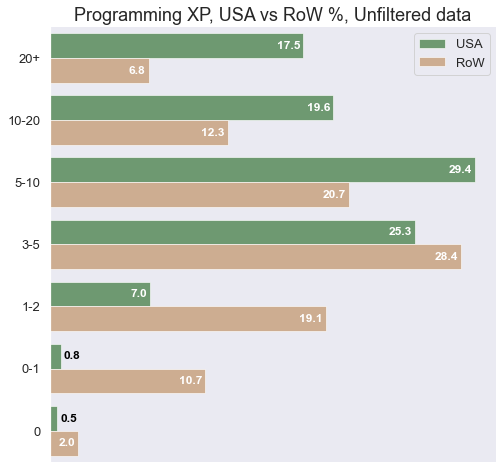

In [16]:
uds_usa = uds[uds.country == "USA"]
uds_non_usa = uds[uds.country != "USA"]
dataset1 = uds_usa
dataset2 = uds_non_usa

column = "code_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
)


kglib.sns_plot_value_count_comparison(
    df,
    width=8,
    height=8,
    orientation="h",
    order_by_labels=False,
    title="Programming XP, USA vs RoW %, Unfiltered data",
    palette=[sns.desaturate("green", 0.75), "peru"]
)

## 4b. Machine learning experience USA vs RoW

After filtering the data and excuding the USA from the global aggragate, we find that:  
#### The relative differences in Data Scientists with experience of more than 10 years is higher compared to the global aggreagares that include the US.

More than one in three respondents (34.5%) from the US have experience of 10 years or more, versus one in five (20.3%) in the RoW.  

Ps. There are two errors in the "Executive Summary", p.10 plot.  
The bin for "10-15 years" should be "10-20 years".
The relative scale for the global bars at the bins of "10-20 years" and "20 or more" has been leveled to almost zero.

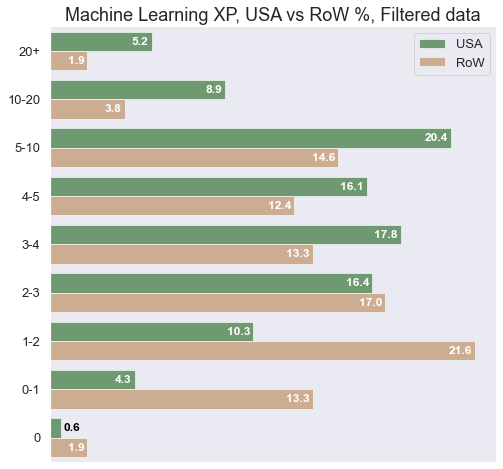

In [17]:
fds_usa = fds[fds.country == "USA"]
fds_non_usa = fds[fds.country != "USA"]
dataset1 = fds_usa
dataset2 = fds_non_usa

column = "ml_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
    #order=order.reverse()
)

kglib.sns_plot_value_count_comparison(
    df,
    width=8,
    height=8,
    orientation="h",
    order_by_labels=False,
    title="Machine Learning XP, USA vs RoW %, Filtered data",
    palette=[sns.desaturate("green", 0.75), "peru"],
)

In [18]:
# (20.3 - 16.3)/16.3

#### 
Using the unfiltered data but excluding the USA from the global aggregates, we see that: 
#### Less than one in 6 respondents have experience of more than 5 years in the RoW (16.3%).  
#### There is a relative reduction of around one fourth in the unfilterd versus unfiltered data, for the respective categories.

Similarly, only 4.5% of Data Scientists in the ROW appear in the unfiltered data to have more than 5 years experience in Machine Learning.

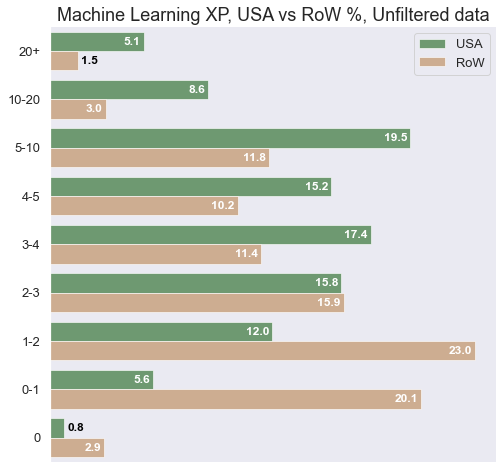

In [19]:
uds_usa = uds[uds.country == "USA"]
uds_non_usa = uds[uds.country != "USA"]
dataset1 = uds_usa
dataset2 = uds_non_usa

column = "ml_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
    #order=order.reverse()
)


kglib.sns_plot_value_count_comparison(
    df,
    width=8,
    height=8,
    orientation="h",
    order_by_labels=False,
    title="Machine Learning XP, USA vs RoW %, Unfiltered data",
    palette=[sns.desaturate("green", 0.75), "peru"]
)

# 5. Salary

## 5a. Global Salary distribution
The unfiltered data global salary distribution exhibits an "anything goes" pattern with three slightly higher density modes which are partly related to unequal bin widhts.  
Note that the "100000-124999" bin width is 2.5 times wider than the "90000-99999" bin width.  
Similarly, if we construct equal size bins by joining the "7500-9999" and the "5000-7499" bins, or all the bins from "1000 to 4999" we will get higher values than the "10000-14999" bin.  
Even worse, what literaly sticks out is the "0-999" bin suggesting that almost one in five Data Scientists globaly earn less than on thousand $USD per year.  

Thankfully, this is related to spam, user-error or probably part-time employement values.  
The picture is not as bleak after filtering the data.  
The filtered data global salary distribution values increase significantly, _from 25 to 30 percentage points_, the density of the three main modes and of their neighboring bins relative to their unfiltered values.  
The three modes indicate hidden patterns in the data resulting in this distribution shape.  
Therefore, we examine the salary distribution:

    a) of the countries with the higher number of participants in the Survey (USA, India, UK, Brazil). 
    These countries happen to belong in different World Bank Income groups.
    
    b) groups of countries according to the World Bank "Income Group" categories.  
    There were no countries in the "Lower" income group in the data.  
    Some participants from countries belonging to this group, might be have been classified in the "Other" country category.  
    Unfortunately, this information is not available to us.

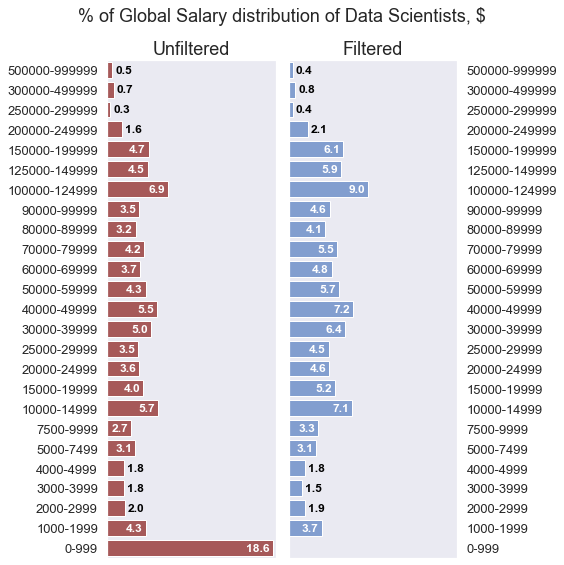

In [20]:
kglib.sns_plot_global_salary_distribution_comparison(
    uds,fds,
    width=8, height=8,
    title="% of Global Salary distribution of Data Scientists, $"
)

## 5b. US salary distribution

Examining the filtered data, we get a clearer idea about what to expect working as a data scientist in the US.  
We should expect, 97% of the times, a minimum staring salary above 70000.  
We find that the US salary distribution is even more concentrated in the 90k to the 200k range.  
Resembling one standard deviation analysis without calculating the mean, we find that more than 70% of salary observations are in the 90k to the 200k range.  
The reason we choose the 90-99k bin instead of the 200-249k bin in order to calculate the cumulative peercentage of 70% of observations has to do with the relative bin widths as discussed previously.  

The 100-125k bin retains its dominant position even if we combine the three bins below it that surpass the 100-125k bin width if we joined them.  
We conclude that the mode of the distibution is the 100k-124999 bin, while the median would probably lie in the 125k-14999 bin.  
The 150-199k bin density is double that the 200-249k bin which has equal witdh but its width is double than the previous two bins.  
While it is a fact that most of the obseravations (23%) are in this range, the other fact is that axis does not have equal scale, creating a kind of visual "illusion".  
This should be noted so that readers get a better understaning of the data.  
Comparing the mode midpoint (112.5k) that we infer by examing the data and the bins, we find that it is higher by two thirds than the average US county salary as reported by the OECD and Eurostat (68700 + (68700*0.66)).  
That is an information that all interested parties should keep in mind.

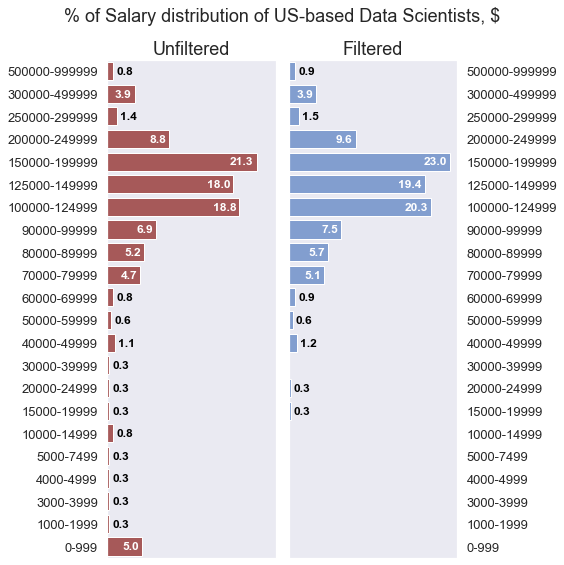

In [21]:
usa_uds = uds[uds.country == "USA"]
usa_fds = fds[fds.country == "USA"]

kglib.sns_plot_global_salary_distribution_comparison(
    usa_uds, usa_fds,
    width=8, height=8,
    x1_limit=(0, 24), x2_limit=(0, 24),
    title="% of Salary distribution of US-based Data Scientists, $"
)

## 5c. India Salary distribution
Examining the filtered data, we find that the Data Scientists salary distribution in India spreads out along a wider range of values.  
As expected, after excluding data that suggested that one third of Data Scientists earn less than 25% of the country average, we can make more reliable inferences.  
Note that there are no observations in the top salary bins despite setting lenient rejection thresholds.  
This highlights the importance of filtering criteria that amy capture a small part of total data, since the might play an important role when examining subsets.

Taking into account the unequal bin size we can see that 69.3% of the observations are in the 4k-4999 range.  
This resonates with the fact the India is classified by the World Bank as a "Lower Middle" income country.  


When we calculate the cumulative percentages of the distribution, we do not include the 40k-49999 bin. 
Instead, we include the 4k-4999 bin, despite the fact that both bins have similar density.  
We do so because the 40-49999 bin is 10 times wider.  
Simalarly, by examining bin widths, we find that the distribution density mode is at the 5k-9999 area (15.7%) including almost 10% more obsrevations than the 10k-14999 bin.  

As in the USA, the mode bin midpoint (7500) is more than two thirds larger than the country average salary.  
This evidence adds support to the general intuition that Data Scentists' salaries are considerably higher than the average country salaries.  
It also indicates that our salary value rejection criteria were lenient indeed.  
As a final note, by examining the filtered data graph, we find evidence that being intentionally lenient, we have allowed for a part of non-normal values to remain in the data in the 1000-1999 bin.  
This also infulences the salary distribution and indicates that it might actually take higher percentage values.  
Pointing out non-normal values should be noted since the identification of such values is a goal in itself in any EDA.

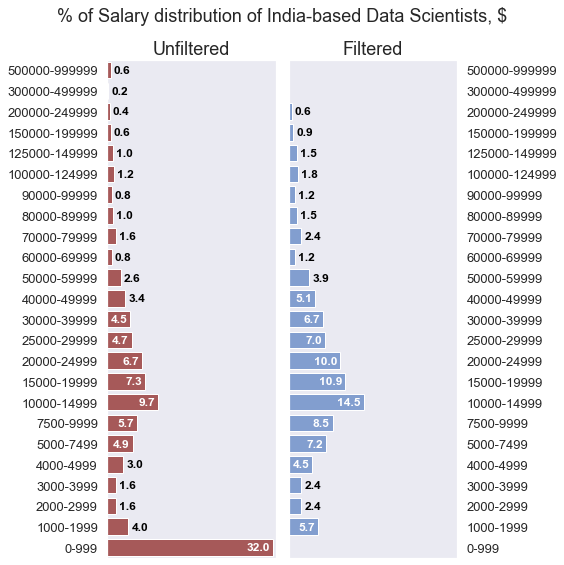

In [22]:
india_uds = uds[uds.country == "India"]
india_fds = fds[fds.country == "India"]

kglib.sns_plot_global_salary_distribution_comparison(
    india_uds, india_fds,
    width=8, height=8,
    x1_limit=(0, 32.5), x2_limit=(0, 32.5),
    title="% of Salary distribution of India-based Data Scientists, $"
)

## 5d. UK salary distribution

The UK salary distribution is also spread out, but a closer look reveals that the 150k-199999 bin sticks out partly due to its relatively large width.  
Still, 36% of values are above the 100k threshold and there is a two-modal pattern in the UK distribution.  
Despite being classified by the World Bank as a "High Income" country, the UK is actually among the top countries in that category in terms of average salary.  
Accounting for experience levels could perhaps explain salary differences more than age or education.

Overall, the UK Data Scientists salary distribution takes values much lower than the in USA.  
This fact, indicates that we should exclude the US from the group of "High Income" countries when examining the salary distribution of the group.  
We took a similar approach when we examined the experience levels in the USA versus the RoW.  

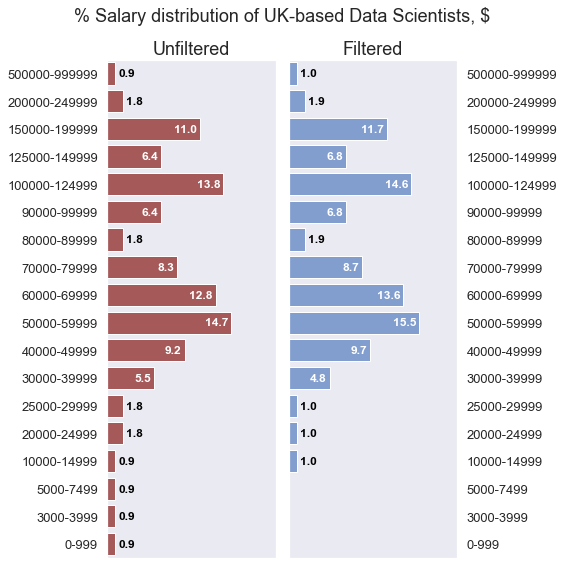

In [23]:
uk_uds = uds[uds.country == "UK"]
uk_fds = fds[fds.country == "UK"]

kglib.sns_plot_global_salary_distribution_comparison(
    uk_uds, uk_fds,
    width=8, height=8,
    x1_limit=(0, 20), x2_limit=(0, 20),
    title="% Salary distribution of UK-based Data Scientists, $"
)

## 5d. Brazil salary distribution

Brazil is classified by the World Bank as an "Upper middle" income country.

The salary distributtion is significantly different than the other three countries we examined.

We see that the majority of observations are in the 10k-59999 range and observation are more evenly distributed in the 10k to 40k range.

The graph indicates that some possible spam and invalid values remain in the "1000-1999" bin.

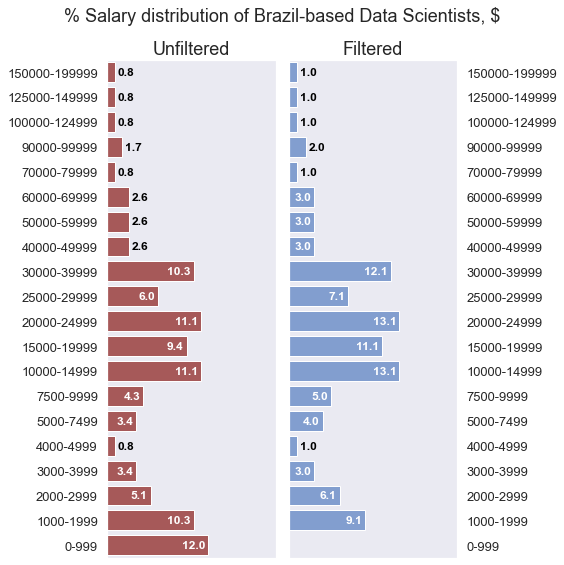

In [39]:
brazil_uds = uds[uds.country == "Brazil"]
brazil_fds = fds[fds.country == "Brazil"]

kglib.sns_plot_global_salary_distribution_comparison(
    brazil_uds, brazil_fds,
    width=8, height=8,
    x1_limit=(0, 20), x2_limit=(0, 20),
    title="% Salary distribution of Brazil-based Data Scientists, $"
)

## 5e. Comparing Medians and section conclusions

Comparing the median salaries of the filtered versus the unfiltered data we find a significant difference for most countries.  

Taking the bin midpoints, we find that the median salary is higher by:

    44% in Japan,
    22% in France,
    40% in Russia,
    40% in Brazil,
    100% in India,
   than the unfiltered data suggest.  

This graph confirms the signifiacnt difference between the US and other countries, in terms of Data Scientists salary.  
There results are similar for the whole data set.

In [ ]:
df = kglib.load_salary_medians_df(
    dataset1=uds,
    dataset2=fds,
    label1="Unfiltered",
    label2="Filtered",
    countries = ["USA", "Germany", "Japan", "France", "Russia", "Brazil", "India"],
)
df

kglib.sns_plot_value_count_comparison(
    df=df, 
    width=8, 
    height=8, 
    orientation="h", 
    order_by_labels=False,
    annotation_mapping=kglib.REVERSE_SALARY_THRESHOLDS,
    title="Median salary for Data Scientists"
)

## 5f. Salary distributions for country "Income groups"

Since the global salary distribution is so diverse, we group the countries in the data according to the World Bank "Income group" criteria, in order to examine possible differences in the distribution.  
Please read Appendix A for relevant info on World Bank "Income Groups".  
As a reminder, the data bins' width in the x-axis is not equal, in fact bins size increases by orders of magnitude.  
We ameliorate this by using logarithmic scale and by adjusting the graph smoothing factor.  

According to the Wordl Bank definition the Income groups comprises countries with wide income differences.  
For example, the "High Income" group includes Romania, Portugal, Germany, Switzerland and the USA.

Ploting the salary by country income groups we get an informative decomposition of the distribution, in contrast to the "everything goes" global view.
We find that the US is a category of its own in the data, taking quite higher values than the rest of the group in the "High Income" countries.
This is another confirmation the USA merits a distinct examination and at the same, when making inference about the RoW the USA should be excluded.  
The graph confirms the USA distribution mode that we could infer by examing the bins' width.  

The "High Income" countries distribution appears to have the vast majority of its values after the mode of the "Upper Middle" income group.

Upper Middle

India

Lower Middle

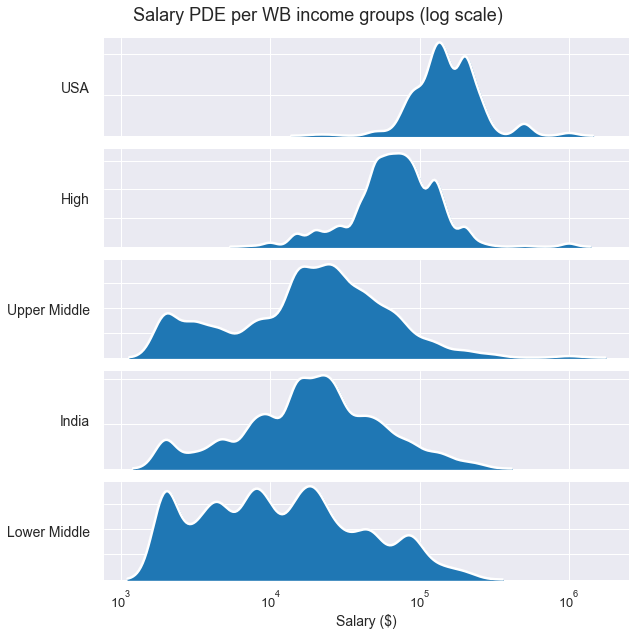

In [42]:
kglib.sns_plot_salary_pde_comparison_per_income_group(
    fds,
    width=9,
    height=9,
    log_scale=True)

## 5g. Salary distributions for Income groups and occupations

In [ ]:
reload_kglib()
kglib.sns_plot_salary_pde_comparison_per_role(
    udf,
    width=16,
    height=9,)

# WIP from here , IGNORE

In [ ]:
kglib.load_median_salary_per_income_group_per_XP_level_df(uds, xp_type="code", income_group="3")
kglib.load_median_salary_per_income_group_per_XP_level_df(uds, xp_type="ml", income_group="3")
kglib.load_median_salary_per_income_group_per_XP_level_df(uds, xp_type="ml")

df = kglib.load_median_salary_comparison_df(uds, fds, xp_type="code", income_group="3")
kglib.sns_plot_value_count_comparison(df, height=8, width=18, bar_width=0.35, title_wrap_length=80, title="Data Scientists: Median salary per Code XP level in High Income countries Filtered vs Unfiltered datasets")

# WIP from here , IGNORE

# WIP from here , IGNORE

In [ ]:
fds_usa = fds[fds.country == "USA"]
fds_non_usa = fds[fds.country != "USA"]

reload_kglib()
df = kglib.load_median_salary_comparison_df(fds_non_usa, fds_usa, xp_type="ml", income_group="3", label1="Non USA DS", label2="USA DS")
kglib.sns_plot_value_count_comparison(
    df, height=8, width=18, bar_width=0.35, title_wrap_length=70, 
    title="Median salary per Machile Learning XP level (filtered dataset)"
)

df = kglib.load_median_salary_comparison_df(fds_non_usa, fds_usa, xp_type="code", income_group="3", label1="Non USA DS", label2="USA DS")
kglib.sns_plot_value_count_comparison(
    df, height=8, width=18, bar_width=0.35, title_wrap_length=70, 
    title="Median salary per Coding XP level (filtered dataset)"
)

3) Us versus other income groups in Median Salary by exper,
4) Us versus RoW in Experience
5) experienced earn double the amount => go for it fellow Kagglers!
6) 

The data point to significantly different results in salary distributions, salary median and experience levels among most countries. In contrast to the "Executive Summary", the data show that the median salary of participants from India is at least at the range of "...", double than the one in the official summary.

Grouping countries according to the World Bank Income Groups. To achieve this, we use official sources when available, we create a combined data set for average salaries and then by using the World Bank Country Income groups we examined the salary distribution in each group, by experience levels.

We reconstruct the various classes (bins) in which the data are provided, accounting for their width. Besides an important shift in the age distribution of participants, the data show that there is currently an acute global shortage of experienced professionals in Programming and Machine Learning, which will not change in the next five years, but maybe afterwards.

Fourthly, we chose a different approach in contrasting the differences of USA versus the world. Since the weight of USA observations is disproportional, when comparing the two we exclude USA from the global aggregates, offering a different view on the pronounced symmetric difference. This shows and even greater shortage of experienced Data Scientists in the Rest of the World (Row).

Combining these four features, and focusing on the other occupations as well, our insights diverge by many degrees to the Executive Summary results, especially with regard to the issue of DS & ML compensation levels. Those results add to the understanding of the data, providing information to students, professionals and interested companies in order to optimize their strategy


## Data Scientist Profile


### Gender


###################

## Appendix A: Appendix A: EDA on spam and user error, methodology


### a) Identifying general "pollution", spam and user error.

Extensive examples of filtering by salary,age, experince by country:

* a) we obtain the annual average salary for each country ("country_avg_salary"), using official sources where available.  
Eurostat, OECD ......

Then, to avoid excluding outliers we set:

* b) the corresponding "salary_threshold" for each observation, as the upper bound of Kaggle data salary bins.
    
    E.g. for a salary value in the "4000-4999" bin the salary threshold we set is "5000".

* c) the country adjusted "low_salary_high_exp" threshold, two thresholds below the country average, applicable only for experience value >= 10 years.
    
    E.g. for USA, average country salary is 65835, the bin threshold is "60000-70000" and the bin upper bound is 70000.  
    So for participants from USA, with 10 or more years of experience, the "low_salary_high_experience" treshold is 50000.  
    Accordingly, the rejection criterion drops values which are below the upper bin bound of 50000 (in the "40000-49999" range).  
    In simple terms, for high experience, we drop observations with salary which are two thresholds below the country average salary upper threshold.
   
* d) the country adjusted "too_low_salary" threshold. We multiply the country average by 0.33 and set the rejection rate to be two thresholds below.  
    
    E.g. for USA residents the average country salary is 65800 and 1/3 of the country average salary is 21945, which is in the "20000-29999" bin.  
    Accordingly, the upper theshold is 30000 and the rejection criterion is applied for values two thresholds below, in the range of "10000-14999".  
    In short, the "too low salary" rejection criterion drops values two thresholds below the threshold of the one third of the country average.

* e) the "high_salary_low_exp" threshold, which is above 300000 for all countries.

    We argue that no one with zero or minimum experience is paid for working as a Data Scientist such a salary.

### Setting the filtering arguments

As mentioned above, the data are filtered using a dedicated function that can be reparameterized on the spot by setting:

- a stricter (higher) or more lenient (lower) value for the "low_salary_percentage" argument,
- a different value in the "threshold_offset" argument,
- by adjusting what is considered to be high or low experience.

Starting from ground zero, we examine the time that it took participant to complete the survey.

Checking duration to complete and number of questions answered, we identified a large set of observations that completed the survey in less than 30 seconds and only answered the first set of basic demographic questions and no other information that would add value concerning the DS & ML Survey. We decided to drop these observations as they offer no information whatsoever about the issues in question, are spam or irrelevant.

But, since meaningful differences in the results concerning DS & ML, originate in observations who spammed the answers instead of not answering them, we set logical thresholds for invalid values, on mutually exclusive value pairs and their combinations.


There are hundreds of observations below 30 seconds. It is impossible to complete a survey of this length in 20 seconds. We could set an arbitrary time threshold here, but we since this points to some people not completing the Survey, we decided there is another way to check this.

Conclusion 1: the spam system method includes participants which did not actually complete the Survey and answered whatever as fast as possible. We could use this criterion to drop many observations, but, we found an optimal one.

Studying the questionnaire we noticed that, as is usual with surveys, the first set of questions included general, demographic ones that could fit in any survey (such as age, gender, country). So, we decided to check which participants did not answer anything besides these question and the next one.

We decided to drop these observations, since they offer nothing to our understanding on DS & ML, other than general demographic variables of those who started the Survey. We could set a more strict spam criterion -e.g. at least 3 non-demographic answers-, but as a general methodological rule we chose have unambiguous lenient criteria for spam classification.

There are various types of irregular values in the data with value of age "18-21" and salary "> 500.000".
eg:


Using official sources, we create an "average salary" threshold for each country. Then, to avoid excluding outliers, we set the "lower than average" threshold to be one level below the average level and two levels for lower income countries. using the lower than average thresholds, we exclude observations with salary lower than one third of the defined threshold, only for participants with experience more than 10 years. 
  
The significance of these observations depends on the overall size of the subset they belong to and the metric that is calculated.
For example, the average salary of someone with 500000$ outweighs 100 observations of salary of $ 5000.
Similarly, dropping 10 observations from a range of 15 observations, means that the size of this category is only one third of its initial unfiltered size.

In total, we drop ... observations and the new data set contains .... rows.

# Appendix B: Data Analysis driven suggestions for future Kaggle Surveys.

    1. Set a mimimum time rejection limit and a maximum "timeout" limit.
    2. Request Age input as integer value.
    3. Education. Ask separately about current obtained title, separately about current studies and separately about plans for the next two years
    4. If employeed ask about first about full or part-time employment
    5. Request Monthly instead of Yearly salary and provide hints to participants.
    6. Request Salary input as integer value
    7. This is not always True: Non-professionals were defined as students, unemployed, and respondents that have never spent any money in the cloud.